<a href="https://colab.research.google.com/github/Ninja-State/NMA-DL-Project/blob/Nour/Copy_of_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1-8 code blocks were adapted from NeuroMatch Academy sample project and Steinmetz data Notebook and from Miguel Nunez.

In [10]:
#@title 1. import libraries
# import packages

import os, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
 
#from torchvision import datasets
#from torch.utils.data import DataLoader
#from torchvision.utils import save_image
#import torchvision.transforms as transforms

In [11]:
# @title 2. Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [12]:
#@title 3. CUDA Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
#@title 4. Plotting params

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [14]:
#@title 5. Loading Spiking times
fname1 = ['steinmetz_st.npz']
fname1.append('steinmetz_wav.npz')
fname1.append('steinmetz_lfp.npz')
url2 = ["https://osf.io/4bjns/download"]
url2.append("https://osf.io/ugm9v/download")
url2.append("https://osf.io/kx3v9/download")


for j in range(len(url2)):
  if not os.path.isfile(fname1[j]):
    try:
      r = requests.get(url2[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname1[j], "wb") as fid:
          fid.write(r.content)


dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']
dat2 = dat_ST[11]
del dat_ST
print(dat2.keys())

dict_keys(['ss', 'ss_passive'])


In [15]:
#@title 6. Load Binned Times

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [16]:
#@title 7. DF form
dt_waveforms = 1/30000 # dt of waveform
binsize = dat['bin_size'] # bin times spikes
mean_firing = dat['spks'].mean(axis = (1,2)) * 1/binsize # computing mean firing rate
t_t_peak = dat['trough_to_peak'] * dt_waveforms * 1e3 # computing trough to peak time in ms


labeling_df = pd.DataFrame({
    "Mean Firing Rate": mean_firing,
    "Trough to peak": t_t_peak,
    "Region": dat['brain_area'],
    "Area":dat['brain_area']
})
labeling_df.replace(
    {
        "Area": {"CA1":"Hippocampus","DG":"Hippocampus","SUB":"Hippocampus",
        "VISp": "Visual Ctx", "VISam":"Visual Ctx","MD":"Thalamus","LGd":"Thalamus", "LH":"Thalamus",
        "PL":"Other Ctx","MOs":"Other Ctx","ACA":"Other Ctx"
        }
    }, inplace = True
)

# Labeling according to conditions, other is the default condition
labeling_df['Cell Type'] = "Other"
labeling_df.loc[(labeling_df['Mean Firing Rate']<5)&(labeling_df['Trough to peak']>0.4),'Cell Type'] = "Excitatory"
labeling_df.loc[(labeling_df['Mean Firing Rate']>5)&(labeling_df['Trough to peak']<0.4), 'Cell Type'] = "Inhibitory"

labeling_df.head(20)

,Mean Firing Rate,Trough to peak,Region,Area,Cell Type
0,0.731765,0.800000,VISp,Visual Ctx,Excitatory
1,0.237647,0.666667,VISp,Visual Ctx,Excitatory
2,5.368235,0.766667,VISp,Visual Ctx,Other
3,0.190588,0.566667,DG,Hippocampus,Excitatory
4,1.356471,0.633333,VISp,Visual Ctx,Excitatory
5,0.000000,0.733333,VISp,Visual Ctx,Excitatory
6,0.141176,0.600000,SUB,Hippocampus,Excitatory
7,2.327059,0.733333,DG,Hippocampus,Excitatory
8,0.030588,0.633333,VISp,Visual Ctx,Excitatory
9,0.798824,0.400000,VISp,Visual Ctx,Other


(1055, 181, 250)


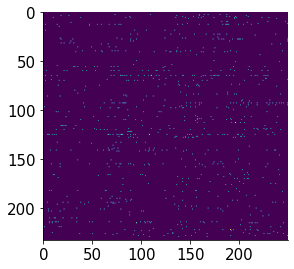

In [18]:
dat = alldat[36]
labeling_df['Region'].unique()
print(dat['spks'].shape)
#Neurons,trials,time
plt.imshow(dat['spks'][dat['brain_area']=='MOs',30,:])

In [19]:
#@title 7. Raster visualizer
from ipywidgets import interact
import ipywidgets as widgets
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)
def raster_visualizer(area,trial):
  spikes= dat2['ss']
  plt.figure(figsize=(9,5))
  plt.eventplot(spikes[labeling_df['Area']==area][:,trial],color='k')
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Excitatory')][:,trial]);
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Other')][:,trial],color='k');
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Inhibitory')][:,trial],colors = 'r');
  #plt.yticks([]);
  plt.vlines(0.5,0,len(spikes[(labeling_df['Area']==area)])-10,'red','--',alpha=0.5)
  plt.ylabel('Neurons');
  plt.xlabel('Time ($s$)');
  plt.title(f'Trial was correct?:{is_correct[trial]}')
interact(raster_visualizer, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx'], trial=(0,339));

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

In [20]:
#@title 8. Mean firing rate based on response
# response = dat['response'] # right - nogo - left (-1, 0, 1)

def mean_firing(area):
  Selection = (labeling_df['Area']==area) #& (labeling_df['Cell Type']=='Excitatory')
  spikes = dat['spks'][Selection].mean(axis = 0) #selecting spikes
  mean_fr_e = spikes[is_correct==True].mean(axis=(0))*1/binsize
  mean_fr_i = spikes[is_correct==False].mean(axis=(0))*1/binsize
  time = binsize * np.arange(dat['spks'].shape[-1])
  plt.plot(time, mean_fr_e,label='correct')
  plt.plot(time, mean_fr_i,label='incorrect')
  plt.axvline(x=0.5,ls = '--', alpha = 0.5, c = 'r', label='Stim')
  plt.axvline(x=np.mean(dat['response_time']),ls = '--', alpha = 0.5, c = 'k', label='Response')
  plt.ylabel('Mean Firing Rate ($Hz$)')
  plt.xlabel('Time ($ms$)')
  plt.legend()
interact(mean_firing, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx']);

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

In [21]:
#dat['spks'][dat['brain_area']=='ZI',:,:]
Data_to_feed = dat['spks']
print(Data_to_feed.shape,Data_to_feed.size)

(1055, 181, 250) 47738750


In [53]:
#@title Constants and Data
a0 = Data_to_feed.shape[0]
a1 = Data_to_feed.shape[1]
a2 = 5 
d22 = np.zeros((a0,a1,a2))
for i in range(5):
  d22[:,:,i] = Data_to_feed[:,:,50*i:50*(i+1)].mean(axis=2)

in_data=torch.tensor(d22.astype(np.float32) ).permute(1,0,2)
print(in_data.shape)


num_epochs = 1000
lr = 1e-3  #learning rate
batch_size = 181
wd = 1e-4
in_dim = in_data.size(1)*in_data.size(2)    
#in_dim = #of Neurons*#of time bins
print(in_dim)
h_dim = [in_dim, 20] #[h_dim[0],h_dim[1],h_dim[2],h_dim[3]] # list of nbs for the hidden layers 


torch.Size([181, 1055, 5])
5275


In [54]:
#@title Autoencoder
class AE(nn.Module):
  def __init__(self,in_dim, hidden_dim):
    super(AE,self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(in_dim,h_dim[0]),
        nn.ReLU(),
        nn.Linear(h_dim[0],h_dim[1]),
        #nn.ReLU(),

        #nn.Linear(h_dim[1],h_dim[2]),
        #nn.ReLU(),
        #nn.Linear(h_dim[2],h_dim[3])
    )
    self.decoder = nn.Sequential(
        #nn.Linear(h_dim[3],h_dim[2]),
        #nn.ReLU(),
        #nn.Linear(h_dim[2],h_dim[1]),
        #nn.ReLU(),
        nn.Linear(h_dim[1],h_dim[0]),
        nn.ReLU(),
        nn.Linear(h_dim[0],in_dim)  
   )
  def forward(self,x):
    flat_x = x.reshape(x.size(0),-1)
    h = self.encoder(flat_x)
    output = self.decoder(h)
    x_out = output.view(x.size())
    return x_out , h 

In [55]:
nonlin_AE = AE(in_dim, h_dim)
nonlin_AE.to(device)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=5275, out_features=5275, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5275, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=5275, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5275, out_features=5275, bias=True)
  )
)

In [56]:
#@title train AE
optimizer = optim.Adam(nonlin_AE.parameters(),lr =lr, weight_decay = wd)
loss_fn = nn.MSELoss()
mse_loss = []
for epoch in range(num_epochs):
  loss=0
  for j in range(1): #batch_size=nbofTrials
    #load batch data to active device 
    batch_ftrs = in_data[batch_size*j:batch_size*(j+1),:,:].to(device) 
    #each iteration, we should set the 
    #gradients back to zero
    optimizer.zero_grad()
    # reconstruct
    reconstucted_output , latents = nonlin_AE(batch_ftrs) 
    # compute the training loss
    training_loss = loss_fn(reconstucted_output.view(batch_ftrs.size(), -1),batch_ftrs.view(batch_ftrs.size(), -1)) 
    # compute back prop to accumlate gradients
    training_loss.backward()
    #update according to current gradients
    optimizer.step()
    #print(loss)
    loss += training_loss.item()
    #print(loss)
  mse_loss.append(loss)
    #print(mse_loss)
  if epoch % 100 == 0:
      print(f'iteration {epoch}, cost {loss:.4f}')
nonlin_AE.to('cpu')

iteration 0, cost 0.0111
iteration 100, cost 0.0018
iteration 200, cost 0.0016
iteration 300, cost 0.0017
iteration 400, cost 0.0017
iteration 500, cost 0.0017
iteration 600, cost 0.0017
iteration 700, cost 0.0017
iteration 800, cost 0.0017
iteration 900, cost 0.0017


AE(
  (encoder): Sequential(
    (0): Linear(in_features=5275, out_features=5275, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5275, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=5275, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5275, out_features=5275, bias=True)
  )
)

In [60]:
reconstucted_output = reconstucted_output.detach().cpu().numpy()
latents = latents.detach().cpu().numpy()

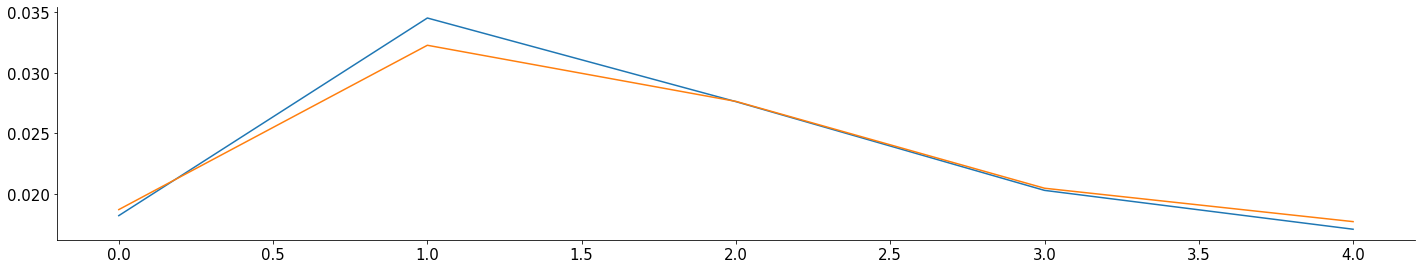

In [61]:
plt.plot(reconstucted_output[:,1053,:].mean(axis=0))
plt.plot(in_data[:,1053,:].mean(axis=0))

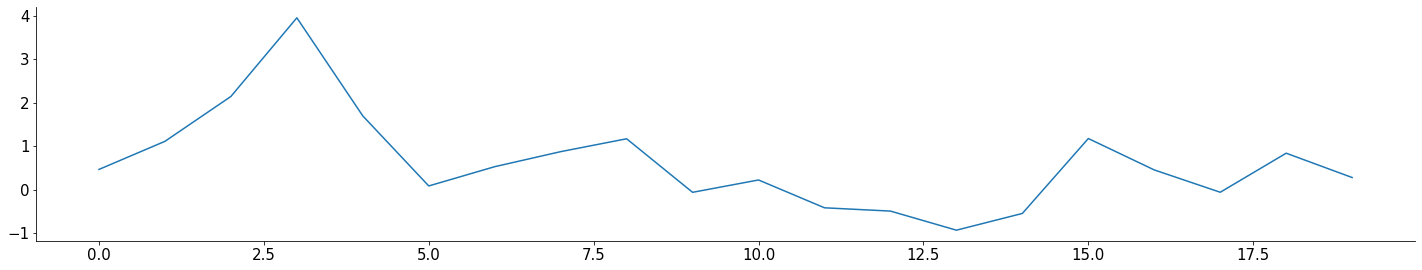

In [65]:
latents.shape
plt.plot(latents[1,:])

(181, 20)

105.5